# TASK 1 CART

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Training Accuracy: 98.11%
Testing Accuracy: 95.45%

Final tree structure:
{'feature': 'PetalLengthCm', 'threshold': 2.45, 'left': 'Iris-setosa', 'right': {'feature': 'PetalLengthCm', 'threshold': 4.75, 'left': {'feature': 'PetalWidthCm', 'threshold': 1.6, 'left': 'Iris-versicolor', 'right': 'Iris-virginica'}, 'right': {'feature': 'PetalWidthCm', 'threshold': 1.75, 'left': {'feature': 'PetalWidthCm', 'threshold': 1.55, 'left': 'Iris-virginica', 'right': 'Iris-versicolor'}, 'right': {'feature': 'PetalLengthCm', 'threshold': 4.85, 'left': 'Iris-virginica', 'right': 'Iris-virginica'}}}}


<Figure size 1200x800 with 0 Axes>

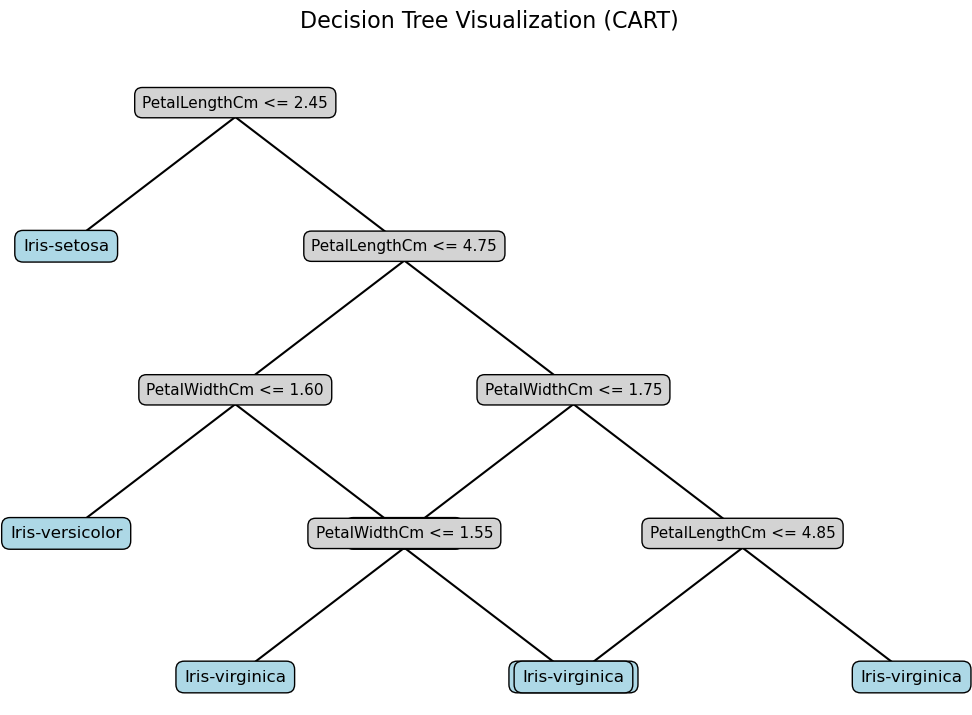

In [ ]:
# Splitting ratios
TRAIN_SIZE = 0.70
TEST_SIZE = 0.30

# Function to preprocess and split data
def preprocess_and_split_data():
    
    iris = pd.read_csv('Iris.csv')  # Load Iris dataset

    # Preprocess dataset
    X = iris.iloc[:, 1:-1].values  # Exclude the ID and labels columns
    y, class_names = pd.factorize(iris['Species'])  # Convert species labels to numerical values and store class names
    feature_names = iris.columns[1:-1].tolist()  # Get feature names

    # Split into train, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

    return X_train, X_test, y_train, y_test, class_names, feature_names

# Function to split dataset into training and testing sets
def train_test_split(X, y, test_size=0.15):
    
    np.random.seed(42)  # For reproducibility
    shuffled_indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)

    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

# Function to calculate Gini impurity
def gini_impurity(y):                    
    
    unique_labels, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

# Function to calculate Information Gain using Gini impurity
def information_gain(X, y, feature_index, threshold):
    
    X_left, X_right, y_left, y_right = split_dataset(X, y, feature_index, threshold)
    parent_impurity = gini_impurity(y)
    n = len(y)
    n_left, n_right = len(y_left), len(y_right)

    if n_left == 0 or n_right == 0:
        return 0

    weighted_impurity = (n_left / n) * gini_impurity(y_left) + (n_right / n) * gini_impurity(y_right)
    return parent_impurity - weighted_impurity

# Function to split dataset based on a feature and a threshold
def split_dataset(X, y, feature_index, threshold):
    
    left_idx = X[:, feature_index] <= threshold
    right_idx = X[:, feature_index] > threshold
    return X[left_idx], X[right_idx], y[left_idx], y[right_idx]

# Function to find the best split
def best_split(X, y):
    
    best_feature = None
    best_threshold = None
    best_gain = -1
    n_samples, n_features = X.shape

    for feature_index in range(n_features):
        feature_values = np.sort(np.unique(X[:, feature_index]))
        midpoints = (feature_values[:-1] + feature_values[1:]) / 2

        for threshold in midpoints:
            gain = information_gain(X, y, feature_index, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold

    return best_feature, best_threshold

# CART recursive function to build the decision tree
def cart(X, y, class_names, depth=0, max_depth=None, min_samples_split=2):
    
    if len(np.unique(y)) == 1:
        return class_names[y[0]]  # Return the class name instead of index

    if len(y) < min_samples_split:
        return class_names[np.bincount(y).argmax()]

    if max_depth is not None and depth >= max_depth:
        return class_names[np.bincount(y).argmax()]

    best_feature, best_threshold = best_split(X, y)

    if best_feature is None:
        return class_names[np.bincount(y).argmax()]

    X_left, X_right, y_left, y_right = split_dataset(X, y, best_feature, best_threshold)

    tree = {
        'feature': feature_names[best_feature],  # Store feature name instead of index
        'threshold': best_threshold,
        'left': cart(X_left, y_left, class_names, depth + 1, max_depth),  # Recursive call for left subtree
        'right': cart(X_right, y_right, class_names, depth + 1, max_depth),  # Recursive call for right subtree
    }

    return tree

# Prediction function for the decision tree
def predict(tree, X, class_names):
    
    if not isinstance(tree, dict):
        return np.full(X.shape[0], tree)  # Return class name directly

    feature_name = tree['feature']
    threshold = tree['threshold']
    
    # Find the feature index corresponding to the feature name
    feature_index = feature_names.index(feature_name)

    left_mask = X[:, feature_index] <= threshold
    right_mask = X[:, feature_index] > threshold

    predictions = np.empty(X.shape[0], dtype=object)  # Object type to store class names
    predictions[left_mask] = predict(tree['left'], X[left_mask], class_names)
    predictions[right_mask] = predict(tree['right'], X[right_mask], class_names)

    return predictions

# Function for evaluating the performance of the model
def evaluate(tree, X_train, y_train, X_test, y_test, class_names):
    
    train_predictions = predict(tree, X_train, class_names)
    test_predictions = predict(tree, X_test, class_names)

    train_accuracy = np.mean(train_predictions == class_names[y_train])
    test_accuracy = np.mean(test_predictions == class_names[y_test])

    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

    return train_accuracy, test_accuracy

# Function to visualize the decision tree
def plot_tree(node, pos=None, parent=None, tree_depth=1, feature_names=None, ax=None):
    
    if pos is None:
        pos = {0: (0, 1)}  # Starting position for root node
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')
    
    if not isinstance(node, dict):
        ax.text(pos[0][0], pos[0][1], str(node), size=12,
                ha='center', va='center', bbox=dict(facecolor='lightblue', boxstyle='round,pad=0.5'))
        return

    feature_name = node['feature']
    threshold = node['threshold']

    ax.text(pos[0][0], pos[0][1], f'{feature_name} <= {threshold:.2f}', size=11,
            ha='center', va='center', bbox=dict(facecolor='lightgray', boxstyle='round,pad=0.5'))

    # Calculate positions for children nodes
    left_pos = (pos[0][0] - 0.25, pos[0][1] - 0.5)
    right_pos = (pos[0][0] + 0.25, pos[0][1] - 0.5)                    
  
    # Draw lines to children
    ax.plot([pos[0][0], left_pos[0]], [pos[0][1] - 0.05, left_pos[1]], color='black')
    ax.plot([pos[0][0], right_pos[0]], [pos[0][1] - 0.05, right_pos[1]], color='black')

    # Recursive calls for children
    plot_tree(node['left'], pos={0: left_pos}, feature_names=feature_names, ax=ax)
    plot_tree(node['right'], pos={0: right_pos}, feature_names=feature_names, ax=ax)                    



    # Preprocess and split data
X_train, X_val, X_test, y_train, y_val, y_test, class_names, feature_names = preprocess_and_split_data()

    # Build the CART tree
tree = cart(X_train, y_train, class_names, max_depth=4)

    # Evaluate the tree on training and testing sets
train_acc_cart,test_acc_cart =evaluate(tree, X_train, y_train, X_test, y_test, class_names)

    # Print the final tree structure
print("\nFinal tree structure:")
print(tree)

    # Visualize the tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=feature_names)
plt.title("Decision Tree Visualization (CART)\n\n", fontsize=16)
plt.show()


# ID3

Training Accuracy: 90.57%
Testing Accuracy: 86.36%

Final tree structure:
{'feature': 'PetalLengthCm', 'threshold': 2.45, 'left': 'Iris-setosa', 'right': {'feature': 'PetalLengthCm', 'threshold': 4.75, 'left': {'feature': 'PetalWidthCm', 'threshold': 1.6, 'left': 'Iris-versicolor', 'right': 'Iris-virginica'}, 'right': {'feature': 'PetalLengthCm', 'threshold': 5.15, 'left': 'Iris-versicolor', 'right': 'Iris-virginica'}}}


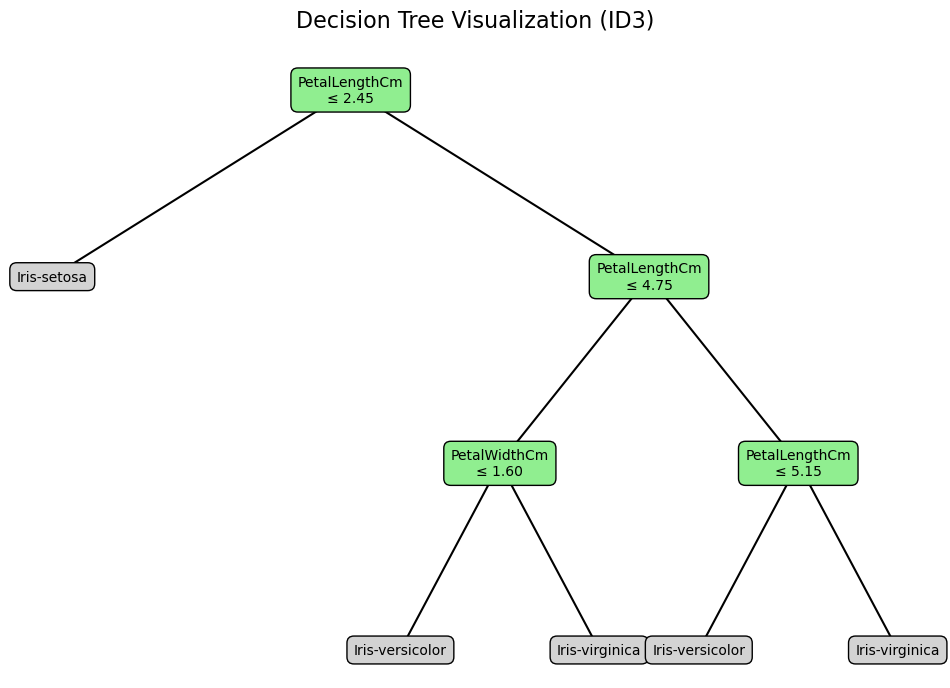

In [ ]:
# Splitting ratios
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Function to preprocess and split data
def preprocess_and_split_data():
    
    iris = pd.read_csv('Iris.csv')  # Load Iris dataset
    
    # Preprocess dataset
    X = iris.iloc[:, 1:-1].values  # Exclude the ID and labels columns
    y, class_names = pd.factorize(iris['Species'])  # Convert species labels to numerical values and store class names
    feature_names = iris.columns[1:-1].tolist()  # 
    
    # Split into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=TEST_SIZE)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VAL_SIZE / (TRAIN_SIZE + VAL_SIZE))
    
    return X_train, X_val, X_test, y_train, y_val, y_test, class_names, feature_names

# Function to split dataset into training and testing sets
def train_test_split(X, y, test_size=0.15):
    
    np.random.seed(42)  # For reproducibility
    shuffled_indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

# Function to calculate entropy
def entropy(y):
    unique_labels, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities))

# Function to calculate Information Gain
def information_gain(X, y, feature_index, threshold):  
    
    X_left, X_right, y_left, y_right = split_dataset(X, y, feature_index, threshold)
    parent_entropy = entropy(y)
    n = len(y)
    n_left, n_right = len(y_left), len(y_right)
    
    if n_left == 0 or n_right == 0:
        return 0
    
    weighted_entropy = (n_left / n) * entropy(y_left) + (n_right / n) * entropy(y_right)
    return parent_entropy - weighted_entropy

# Function to split dataset based on a feature and a threshold
def split_dataset(X, y, feature_index, threshold):
    
    left_idx = X[:, feature_index] <= threshold
    right_idx = X[:, feature_index] > threshold
    return X[left_idx], X[right_idx], y[left_idx], y[right_idx]

# Function to find the best split
def best_split(X, y, feature_names):

    best_feature = None
    best_threshold = None
    best_gain = -1
    n_samples, n_features = X.shape
    
    for feature_index in range(n_features):
        feature_values = np.sort(np.unique(X[:, feature_index]))
        midpoints = (feature_values[:-1] + feature_values[1:]) / 2
        
        for threshold in midpoints:
            gain = information_gain(X, y, feature_index, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold
    
    return best_feature, best_threshold

# ID3 recursive function to build the decision tree
def id3(X, y, class_names, feature_names, depth=0, max_depth=None, min_samples_split=2):
    
    if len(np.unique(y)) == 1:
        return class_names[y[0]]                      
  
    
    if len(y) < min_samples_split:
        return class_names[np.bincount(y).argmax()]

    if max_depth is not None and depth >= max_depth:
        return class_names[np.bincount(y).argmax()]
    
    best_feature, best_threshold = best_split(X, y, feature_names)
    
    if best_feature is None:
        return class_names[np.bincount(y).argmax()]
    
    X_left, X_right, y_left, y_right = split_dataset(X, y, best_feature, best_threshold)
    
    tree = {
        'feature': feature_names[best_feature], 
        'threshold': best_threshold,
        'left': id3(X_left, y_left, class_names, feature_names, depth + 1, max_depth),  
        'right': id3(X_right, y_right, class_names, feature_names, depth + 1, max_depth),  
    }
    
    return tree

# Function for post-pruning based on validation data                    
def post_prune(tree, X_val, y_val, class_names, feature_names):
    
    if not isinstance(tree, dict):
        return tree
    
    tree['left'] = post_prune(tree['left'], X_val, y_val, class_names, feature_names)
    tree['right'] = post_prune(tree['right'], X_val, y_val, class_names, feature_names)
    
    original_predictions = predict(tree, X_val, class_names)
    original_accuracy = np.mean(original_predictions == class_names[y_val])

    majority_class = np.bincount(y_val).argmax()
    pruned_accuracy = np.mean(np.full(len(y_val), majority_class) == y_val)
    
    if pruned_accuracy > original_accuracy:
        return class_names[majority_class]  # Return class name 
    
    return tree

# Prediction function for the decision tree
def predict(tree, X, class_names):
    
    if not isinstance(tree, dict):
        return np.full(X.shape[0], tree)  # Return class name directly
    
    feature = tree['feature']
    threshold = tree['threshold']
    
    # Find the feature index based on the feature name
    feature_index = feature_names.index(feature)

    left_mask = X[:, feature_index] <= threshold
    right_mask = X[:, feature_index] > threshold
    
    predictions = np.empty(X.shape[0], dtype=object)  # store class names
    predictions[left_mask] = predict(tree['left'], X[left_mask], class_names)
    predictions[right_mask] = predict(tree['right'], X[right_mask], class_names)                                                                                          
    return predictions

# Evaluation function
def evaluate(tree, X_train, y_train, X_test, y_test, class_names):
    
    train_predictions = predict(tree, X_train, class_names)
    test_predictions = predict(tree, X_test, class_names)
    
    train_accuracy = np.mean(train_predictions == class_names[y_train])
    test_accuracy = np.mean(test_predictions == class_names[y_test])
    
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
    return train_accuracy, test_accuracy

            
# Function to plot the decision tree
def plot_tree(node, pos=None, parent=None, graph=None, depth=0, width=2.0, feature_names=None):
    if graph is None:
        graph = {}
    if pos is None:
        pos = (0, 0)

    # Determine if the current node is a leaf or a split
    if isinstance(node, dict):
        
        feature_name = node['feature']  
        threshold = node['threshold']
        
        graph[pos] = (feature_name, threshold)  # Store the node info                    
  
        
        # Draw the node with feature and threshold
        plt.text(pos[0], pos[1], f"{feature_name}\n≤ {threshold:.2f}", ha='center', va='center',
                 bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.5'))

        # Calculate positions for left and right children
        left_pos = (pos[0] - width / (depth + 1), pos[1] - 1)
        right_pos = (pos[0] + width / (depth + 1), pos[1] - 1)
        
        # Draw edges to children
        plt.plot([pos[0], left_pos[0]], [pos[1], left_pos[1]], 'k-')
        plt.plot([pos[0], right_pos[0]], [pos[1], right_pos[1]], 'k-')
        
        # Recursively plot left and right children                                        
        plot_tree(node['left'], pos=left_pos, parent=pos, graph=graph, depth=depth + 1, width=width, feature_names=feature_names)
        plot_tree(node['right'], pos=right_pos, parent=pos, graph=graph, depth=depth + 1, width=width, feature_names=feature_names)
    else:
        # Leaf node                                       
  
        plt.text(pos[0], pos[1],  node, ha='center', va='center',
                 bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))

    return graph

def draw_tree(tree, feature_names):
    plt.figure(figsize=(12, 8))
    plot_tree(tree, feature_names=feature_names)
    
    # Format plot
    plt.title("Decision Tree Visualization (ID3)\n", fontsize=16)
    plt.axis('off')  # Hide axes
    plt.show()



    
    # Preprocess and split data
X_train, X_val, X_test, y_train, y_val, y_test, class_names, feature_names = preprocess_and_split_data()
    
    # Build the ID3 tree
tree = id3(X_train, y_train, class_names, feature_names, max_depth=4)                                      
  
  
    
    # Post-prune the tree using validation data
pruned_tree = post_prune(tree, X_val, y_val, class_names, feature_names)  
    
    # Evaluate the pruned tree on training and testing sets
train_acc_ID3,test_acc_ID3 =evaluate(pruned_tree, X_train, y_train, X_test, y_test, class_names)
    
    # Print the final pruned tree
print("\nFinal tree structure:")
print(pruned_tree)
    
    # Draw the tree
draw_tree(pruned_tree, feature_names)


# Random Forest


In [110]:
# Splitting ratios                    
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
NUM_TREES = 30  # Number of trees in the Random Forest

In [111]:
# Function to preprocess and split data
def preprocess_and_split_data():
    iris = pd.read_csv('Iris.csv')  # Load Iris dataset

    # Preprocess dataset
    X = iris.iloc[:, 1:-1].values  # Exclude the ID and labels columns
    y, class_names = pd.factorize(iris['Species'])  # Convert species labels to numerical values
    feature_names = iris.columns[1:-1].tolist()  # Get feature names

    # Split into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=TEST_SIZE)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VAL_SIZE / (TRAIN_SIZE + VAL_SIZE))

    return X_train, X_val, X_test, y_train, y_val, y_test, class_names, feature_names

In [112]:
def train_test_split(X, y, test_size=0.15):
    np.random.seed(42)  # For reproducibility
    shuffled_indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)

    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test


In [113]:
# Function to calculate Gini impurity
def gini_impurity(y):                    
    unique_labels, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

In [114]:
# Function to split dataset based on a feature and a threshold
def split_dataset(X, y, feature_index, threshold):                    
    left_idx = X[:, feature_index] <= threshold
    right_idx = X[:, feature_index] > threshold
    return X[left_idx], X[right_idx], y[left_idx], y[right_idx]

In [115]:
# Function to find the best split
def best_split(X, y):
    best_feature = None
    best_threshold = None
    best_gain = -1
    n_samples, n_features = X.shape

    for feature_index in range(n_features):
        feature_values = np.sort(np.unique(X[:, feature_index]))
        midpoints = (feature_values[:-1] + feature_values[1:]) / 2

        for threshold in midpoints:
            gain = information_gain(X, y, feature_index, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold

    return best_feature, best_threshold

In [116]:
# Function to calculate Information Gain using Gini impurity
def information_gain(X, y, feature_index, threshold):                    
    X_left, X_right, y_left, y_right = split_dataset(X, y, feature_index, threshold)
    parent_impurity = gini_impurity(y)
    n = len(y)
    n_left, n_right = len(y_left), len(y_right)

    if n_left == 0 or n_right == 0:
        return 0

    weighted_impurity = (n_left / n) * gini_impurity(y_left) + (n_right / n) * gini_impurity(y_right)
    return parent_impurity - weighted_impurity

In [117]:
# CART recursive function to build the decision tree
def cart(X, y, max_depth=None, depth=0):
    if len(np.unique(y)) == 1:
        return y[0]                      
  

    if len(y) < 2:
        return y[0]

    if max_depth is not None and depth >= max_depth:
        return np.argmax(np.bincount(y))  # Return the majority class

    best_feature, best_threshold = best_split(X, y)

    if best_feature is None:
        return np.argmax(np.bincount(y))

    X_left, X_right, y_left, y_right = split_dataset(X, y, best_feature, best_threshold)

    tree = {
        'feature': best_feature,
        'threshold': best_threshold,
        'left': cart(X_left, y_left, max_depth, depth + 1),  # Recursive call for left subtree
        'right': cart(X_right, y_right, max_depth, depth + 1),  # Recursive call for right subtree
    }

    return tree

In [118]:
# Function for predicting class labels
def predict(tree, X):
    if not isinstance(tree, dict):
        return np.full(X.shape[0], tree)                      
  

    feature_index = tree['feature']
    threshold = tree['threshold']

    left_mask = X[:, feature_index] <= threshold
    right_mask = X[:, feature_index] > threshold

    predictions = np.empty(X.shape[0], dtype=int)  # Store class indices
    predictions[left_mask] = predict(tree['left'], X[left_mask])
    predictions[right_mask] = predict(tree['right'], X[right_mask])

    return predictions

In [ ]:
# Function to build Random Forest using bagging
def random_forest(X, y, n_trees=100, max_depth=3):                    
    trees = []
    n_samples = len(X)

    for _ in range(n_trees):
        # sample with replacement
        sample_indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample = X[sample_indices]
        y_sample = y[sample_indices]

        # Build a decision tree using the dataset
        tree = cart(X_sample, y_sample, max_depth)
        trees.append(tree)

    return trees

In [120]:
# Function to predict using Random Forest
def rf_predict(trees, X):                    
    tree_predictions = np.array([predict(tree, X) for tree in trees])
    # Use the mode of predictions from all trees
    return np.array([np.argmax(np.bincount(tree_preds)) for tree_preds in tree_predictions.T])

In [121]:
# Function for evaluating the performance of the model
def evaluate(trees, X_train, y_train, X_test, y_test, class_names):
    train_predictions = rf_predict(trees, X_train)
    test_predictions = rf_predict(trees, X_test)

    train_accuracy = np.mean(train_predictions == y_train)
    test_accuracy = np.mean(test_predictions == y_test)

    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

    return train_predictions, test_predictions, test_accuracy

In [122]:
# Function to print the tree structure with feature names
def print_tree(tree, feature_names):
    if not isinstance(tree, dict):
        return class_names[tree]  

    feature_name = feature_names[tree['feature']]
    threshold = tree['threshold']
    left_subtree = print_tree(tree['left'], feature_names)
    right_subtree = print_tree(tree['right'], feature_names)

    return {
        'feature': feature_name,
        'threshold': threshold,
        'left': left_subtree,
        'right': right_subtree,
    }


In [123]:
# Function to calculate accuracy of individual trees
def tree_accuracy(tree, X, y):
    predictions = predict(tree, X)
    accuracy = np.mean(predictions == y)
    return accuracy


In [124]:
X_train, X_val, X_test, y_train, y_val, y_test, class_names, feature_names = preprocess_and_split_data()

# Build the Random Forest
trees = random_forest(X_train, y_train, n_trees=NUM_TREES, max_depth=3)

# Evaluate the Random Forest
train_preds, test_preds, accuracy_rf = evaluate(trees, X_train, y_train, X_test, y_test, class_names)




Training Accuracy: 96.23%
Testing Accuracy: 100.00%


In [125]:
# Print the final tree structure
print("\nFinal tree structure:")
for i, tree in enumerate(trees):
    structured_tree = print_tree(tree, feature_names)
    print(f"\nTree {i + 1} structure:")
    print(structured_tree)


Final tree structure:

Tree 1 structure:
{'feature': 'PetalLengthCm', 'threshold': 2.45, 'left': 'Iris-setosa', 'right': {'feature': 'PetalLengthCm', 'threshold': 4.75, 'left': 'Iris-versicolor', 'right': {'feature': 'PetalWidthCm', 'threshold': 1.75, 'left': 'Iris-virginica', 'right': 'Iris-virginica'}}}

Tree 2 structure:
{'feature': 'PetalLengthCm', 'threshold': 2.45, 'left': 'Iris-setosa', 'right': {'feature': 'PetalLengthCm', 'threshold': 4.800000000000001, 'left': {'feature': 'PetalWidthCm', 'threshold': 1.6, 'left': 'Iris-versicolor', 'right': 'Iris-virginica'}, 'right': {'feature': 'PetalLengthCm', 'threshold': 5.05, 'left': 'Iris-virginica', 'right': 'Iris-virginica'}}}

Tree 3 structure:
{'feature': 'PetalLengthCm', 'threshold': 2.45, 'left': 'Iris-setosa', 'right': {'feature': 'PetalLengthCm', 'threshold': 4.85, 'left': {'feature': 'SepalLengthCm', 'threshold': 4.95, 'left': 'Iris-virginica', 'right': 'Iris-versicolor'}, 'right': {'feature': 'PetalWidthCm', 'threshold': 1.7


Individual Tree Accuracies:
Tree 1 Accuracy: 95.45%
Tree 2 Accuracy: 100.00%
Tree 3 Accuracy: 100.00%
Tree 4 Accuracy: 95.45%
Tree 5 Accuracy: 95.45%
Tree 6 Accuracy: 100.00%
Tree 7 Accuracy: 95.45%
Tree 8 Accuracy: 100.00%
Tree 9 Accuracy: 95.45%
Tree 10 Accuracy: 95.45%
Tree 11 Accuracy: 100.00%
Tree 12 Accuracy: 95.45%
Tree 13 Accuracy: 100.00%
Tree 14 Accuracy: 95.45%
Tree 15 Accuracy: 100.00%
Tree 16 Accuracy: 100.00%
Tree 17 Accuracy: 100.00%
Tree 18 Accuracy: 95.45%
Tree 19 Accuracy: 95.45%
Tree 20 Accuracy: 95.45%
Tree 21 Accuracy: 100.00%
Tree 22 Accuracy: 95.45%
Tree 23 Accuracy: 90.91%
Tree 24 Accuracy: 100.00%
Tree 25 Accuracy: 95.45%
Tree 26 Accuracy: 95.45%
Tree 27 Accuracy: 100.00%
Tree 28 Accuracy: 100.00%
Tree 29 Accuracy: 100.00%
Tree 30 Accuracy: 95.45%


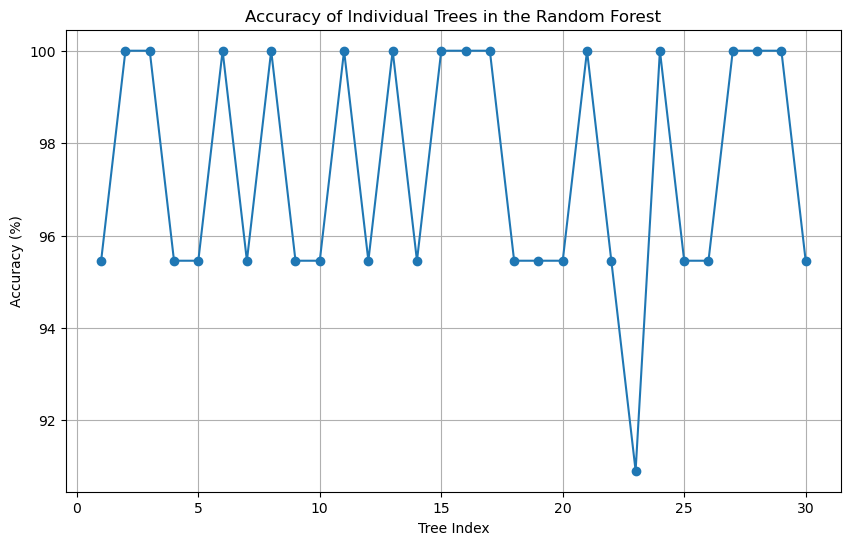

In [126]:
# Print the accuracy for each tree    
print("\nIndividual Tree Accuracies:")
for i, tree in enumerate(trees):
    accuracy = tree_accuracy(tree, X_test, y_test)
    print(f"Tree {i + 1} Accuracy: {accuracy * 100:.2f}%")
    # Plot the accuracy of each tree

tree_accuracies = [tree_accuracy(tree, X_test, y_test) for tree in trees]
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_TREES + 1), [acc * 100 for acc in tree_accuracies], marker='o')
plt.xlabel('Tree Index')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Individual Trees in the Random Forest')
plt.grid(True)
plt.show()

# TASK 3 
# Naive Bayes

In [127]:
# Load data
data = pd.read_csv("Iris.csv", usecols=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'])
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# Prepare the data
X = data.drop('species', axis=1).values
y = data['species'].values

In [128]:
np.random.seed(2)  # For reproducibility
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

train_size = int(0.8 * X.shape[0])
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [ ]:
# (Min-Max Normalization)
def min_max_scaler(X):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    return (X - X_min) / (X_max - X_min)

In [130]:
X_train_scaled = min_max_scaler(X_train)
X_test_scaled = min_max_scaler(X_test)

In [ ]:
# Naive Bayes classifier
def naive_bayes(X, y):
    mean = {}
    variance = {}
    prior = {}
    classes = np.unique(y)

    for c in classes:
        X_c = X[y == c]
        mean[c] = np.mean(X_c, axis=0)
        variance[c] = np.var(X_c, axis=0)
        prior[c] = len(X_c) / len(X)

    return mean, variance, prior, classes

In [ ]:
def gaussian(x, mean, var):
    epsilon = 1e-10  # Small value to avoid division by zero
    numerator = np.exp(-(x - mean) ** 2 / (2 * (var + epsilon)))
    denominator = np.sqrt(2 * np.pi * (var + epsilon))
    return numerator / denominator

In [ ]:
def predict_naive_bayes(X, mean, variance, prior, classes):
    predictions = []
    for x in X:
        posteriors = []
        for c in classes:
            prior_log = np.log(prior[c])
            likelihood = np.sum(np.log(gaussian(x, mean[c], variance[c])))
            posterior = prior_log + likelihood
            posteriors.append(posterior)
        predictions.append(classes[np.argmax(posteriors)])
    return np.array(predictions)

In [ ]:
mean, variance, prior, classes = naive_bayes(X_train_scaled, y_train)

In [135]:
y_pred = predict_naive_bayes(X_test_scaled, mean, variance, prior, classes)

In [136]:
accuracy = np.mean(y_pred == y_test)
print(f'Naive Bayes Test Accuracy: {accuracy * 100:.2f}%')

Naive Bayes Test Accuracy: 90.00%


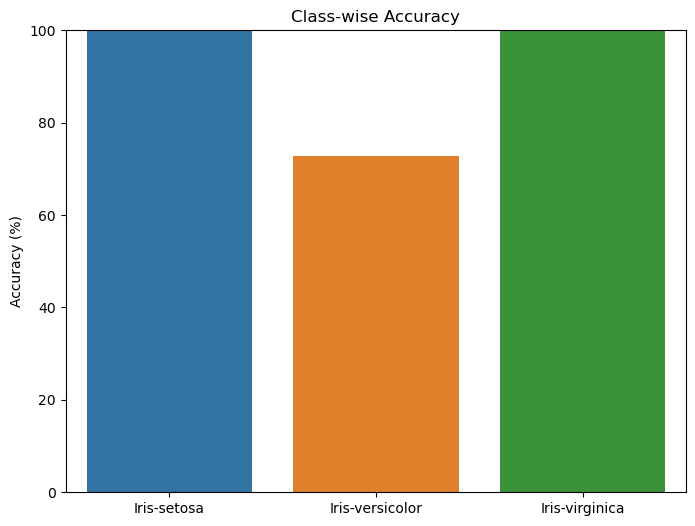

In [139]:
correct_pred = np.array([np.sum((y_pred == cls) & (y_test == cls)) for cls in classes])
total_actual = np.array([np.sum(y_test == cls) for cls in classes])
class_wise_accuracy = correct_pred / total_actual


plt.figure(figsize=(8, 6))
sns.barplot(x=classes, y=class_wise_accuracy * 100)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy')
plt.ylim(0, 100)
plt.show()


# Comparison Between All Models 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


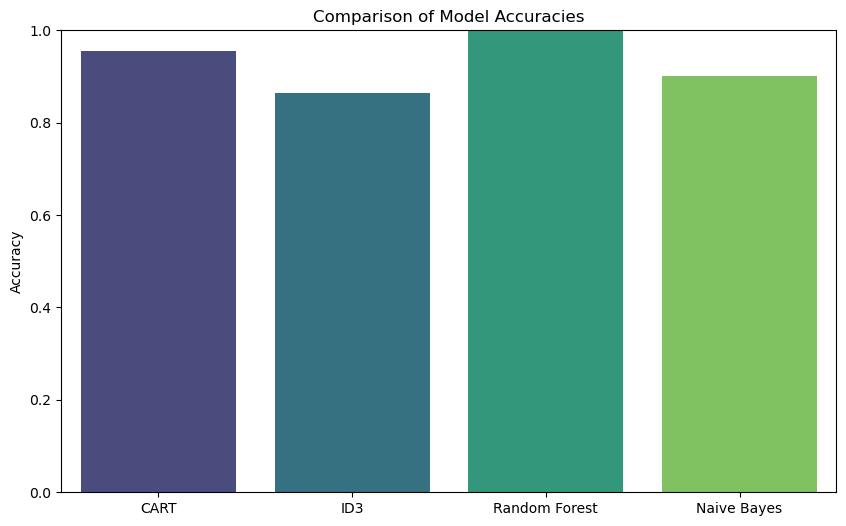

In [140]:

accuracy_cart = test_acc_cart  
accuracy_id3 = test_acc_ID3
accuracy_nb = accuracy  
models = ['CART', 'ID3', 'Random Forest', 'Naive Bayes']
accuracies = [accuracy_cart, accuracy_id3, accuracy_rf, accuracy_nb]


plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()

In [4]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# Function to calculate Gini Impurity
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

# Function to calculate the weighted Gini Impurity after a split
def weighted_gini(groups, y):
    total_instances = len(y)
    return sum((len(group) / total_instances) * gini_impurity(y[group]) for group in groups)

# Function to find the best split
def best_split(X, y, feature_subset):
    best_feature, best_value, best_score, best_groups = None, None, float('inf'), None
    for feature in feature_subset:
        for value in np.unique(X[:, feature]):
            left_indices = np.where(X[:, feature] <= value)[0]
            right_indices = np.where(X[:, feature] > value)[0]
            score = weighted_gini([left_indices, right_indices], y)
            if score < best_score:
                best_feature, best_value, best_score, best_groups = feature, value, score, (left_indices, right_indices)
    return best_feature, best_value, best_groups

# CART Tree
def cart(X, y, max_depth, min_samples_split, depth=0):
    if len(np.unique(y)) == 1 or len(y) < min_samples_split or depth >= max_depth:
        return np.bincount(y).argmax()
    
    feature_subset = np.random.choice(X.shape[1], size=int(np.sqrt(X.shape[1])), replace=False)
    feature, value, (left_indices, right_indices) = best_split(X, y, feature_subset)
    if left_indices.size == 0 or right_indices.size == 0:
        return np.bincount(y).argmax()
    
    tree = {"feature": feature, "value": value, "left": None, "right": None}
    tree["left"] = cart(X[left_indices], y[left_indices], max_depth, min_samples_split, depth + 1)
    tree["right"] = cart(X[right_indices], y[right_indices], max_depth, min_samples_split, depth + 1)
    return tree

# Prediction for CART
def predict_tree(tree, sample):
    if not isinstance(tree, dict):
        return tree
    if sample[tree["feature"]] <= tree["value"]:
        return predict_tree(tree["left"], sample)
    else:
        return predict_tree(tree["right"], sample)

# Random Forest
def random_forest(X, y, n_trees, max_depth, min_samples_split, sample_size=None):
    trees = []
    for _ in range(n_trees):
        # Bootstrap sampling
        indices = np.random.choice(len(y), size=sample_size or len(y), replace=True)
        X_sample, y_sample = X[indices], y[indices]

        # Train a CART tree
        tree = cart(X_sample, y_sample, max_depth, min_samples_split)
        trees.append(tree)
    return trees

# Prediction for Random Forest
def predict_forest(trees, X):
    predictions = []
    for sample in X:
        votes = [predict_tree(tree, sample) for tree in trees]
        predictions.append(Counter(votes).most_common(1)[0][0])
    return predictions
def preprocess_and_split_data():
    
    iris = pd.read_csv('Iris.csv')  # Load Iris dataset

    # Preprocess dataset
    X = iris.iloc[:, 1:-1].values  # Exclude the ID and labels columns
    y, class_names = pd.factorize(iris['Species'])  # Convert species labels to numerical values and store class names
    feature_names = iris.columns[1:-1].tolist()  # Get feature names

    # Split into train, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    return X_train, X_test, y_train, y_test, class_names, feature_names
# Main function
if __name__ == "__main__":
    # Example dataset: Features -> Labels
    data = pd.DataFrame({
        'Feature1': [2.7, 1.2, 3.6, 5.0, 4.8, 3.1, 2.5, 4.1, 1.5, 5.2],
        'Feature2': [2.5, 1.5, 3.7, 4.9, 4.8, 2.9, 2.4, 4.0, 1.4, 5.3],
        'Label': [0, 0, 1, 1, 1, 0, 0, 1, 0, 1]
    })
    
    

    # Train-test split
    X_train, X_test, y_train, y_test, class_names, feature_names = preprocess_and_split_data()

    # Build Random Forest
    forest = random_forest(X_train, y_train, n_trees=50, max_depth=5, min_samples_split=2, sample_size=int(0.8 * len(X_train)))

    # Predict
    predictions = predict_forest(forest, X_test)
    print("Test Predictions:", predictions)
    print("Actual Labels:", y_test)


Test Predictions: [1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 0, 0, 2, 2, 2, 0, 1, 2, 1, 0, 2, 2, 2, 2]
Actual Labels: [2 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 0 0 1 2 2 0 1 2 1 0 2 2 2 2]
